# 音の情報処理４：短時間フーリエ変換によるスペクトログラム計算

## 1. 短時間フーリエ変換

周波数分解は、先ほどの「あ」のみの音声のように、時間的に周波数成分があまり変化しない音を分析するにはいいですが、   
単語を発しているときの音声や音楽のように、時間とともに音の高さが変わるものを分析しようとすると、  
それらの波がすべて混ざって分析されてしまいます。   
一方で、周波数分解はある瞬間（つまり1サンプルのみということになります）の波からは計算できません。   
時間的な周波数特徴の変化を分析するためにはどうしたらいいでしょうか？

音のある瞬間の周波数成分は、その瞬間の周辺（前後）の音から計算できると思いませんか？  
つまり、音声ファイルを短い時間で区切って、そのそれぞれの短い音声から周波数成分を計算し、  
それを時間方向に並べるというアイディアです。  

ただし、本当は前後の音に左右されずその瞬間の音だけの周波数成分を計算したいので、   
その瞬間の波形の影響が最も大きく、その瞬間から離れるにつれてその影響が小さくなるようにしたいですね。  

そこで、  
 1) 波形を短く区切る  
 2) 短く区切った波形に、中心が大きくて、中心が離れるほど小さくなるような重みをかける  
 3) フーリエ変換して周波数特徴に変換したあと、その対数パワースペクトルを時間方向に並べる  
といった処理を行うことで、周波数の時間変化を可視化します。  
このような処理を短時間フーリエ変換（Sohrt Time Fourie Transfer: STFT)と呼び、その結果を可視化したものをスペクトログラムと呼びます。

## 2. ライブラリを使ったスペクトログラムの計算お呼び描画

短時間フーリエ変換の計算にはspecgramという関数があります。  
とにかく動かしてみましょう。

16000


<IPython.core.display.Javascript object>


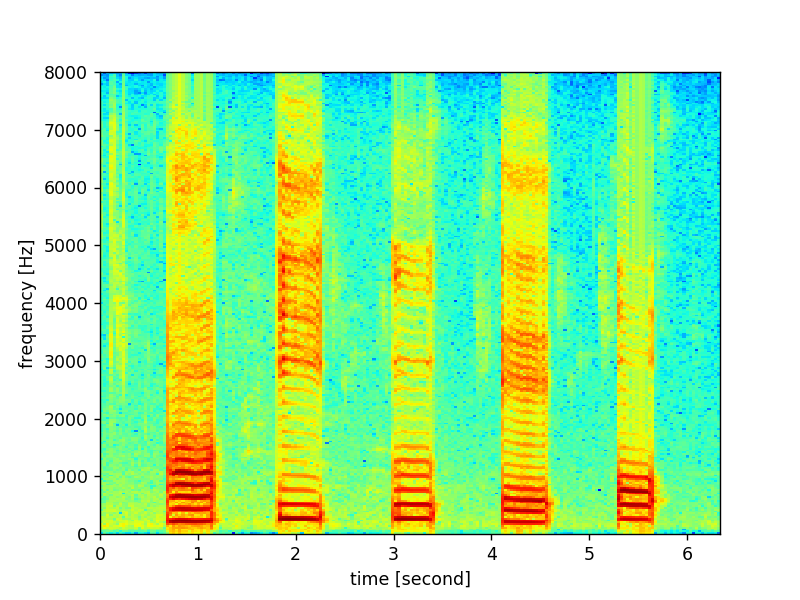

In [2]:
%matplotlib notebook

import wave
from pylab import *
import numpy as np

wavfile = wave.open("sounds/female_aiueo.wav" , "rb" ) # オーディオファイルを開く
#wavfile = wave.open("sounds/male_aiueo.wav" , "rb" ) # オーディオファイルを開く

# wavfileのデータを最後まで一気に読み込む（データサイズが大きいファイルを読み込むときは、読み込むサイズを指定しないとPCがフリーズします）。
x = wavfile.readframes(wavfile.getnframes())
x = np.frombuffer(x, dtype= "int16") # バイナリデータをint型に変換
sampling_rate = wavfile.getframerate()
print(sampling_rate)
wavfile.close()

# 短く切り出すときの幅（切り出すフレームの数）
N = 512

# FFTで用いるハミング窓
hammingWindow = np.hamming(N)

# スペクトログラムを描画
# cmap
pxx, freqs, bins, im = specgram(x,# 元の波形 
                                NFFT=N, # 切り出す幅
                                Fs=sampling_rate, # サンプリングレート
                                noverlap=0, # 0から順番に切り出していくとき、重複して切り出すならここで重複させるフレーム数を指定
                                window=hammingWindow, # 窓関数の指定
                                cmap=cm.jet) # カラーマップ：値の大きさによって色を塗り分ける。
                                            # 様々なカラーマップが用意されている。
                                            # 参照：https://matplotlib.org/examples/color/colormaps_reference.html

#axis([0, length, 0, wf.getframerate() / 2])
xlabel("time [second]")
ylabel("frequency [Hz]")
plt.savefig('fig/SoundProcessing4-1.png') # 図を画像として保存

## 時刻tの短時間フーリエスペクトルの計算方法
たとえば$t=1.0$ secの短時間フーリエスペクトル（上のグラフではx軸が1.0秒のときの縦方向の縞模様）の計算方法を見て見ましょう。  
1 kHzあたりまでの間に縞模様が5本あることを覚えておいてください。  
この音声ファイルのサンプリングレートは16kHzですから、1秒後は$16000$フレーム目ということになります。

<IPython.core.display.Javascript object>


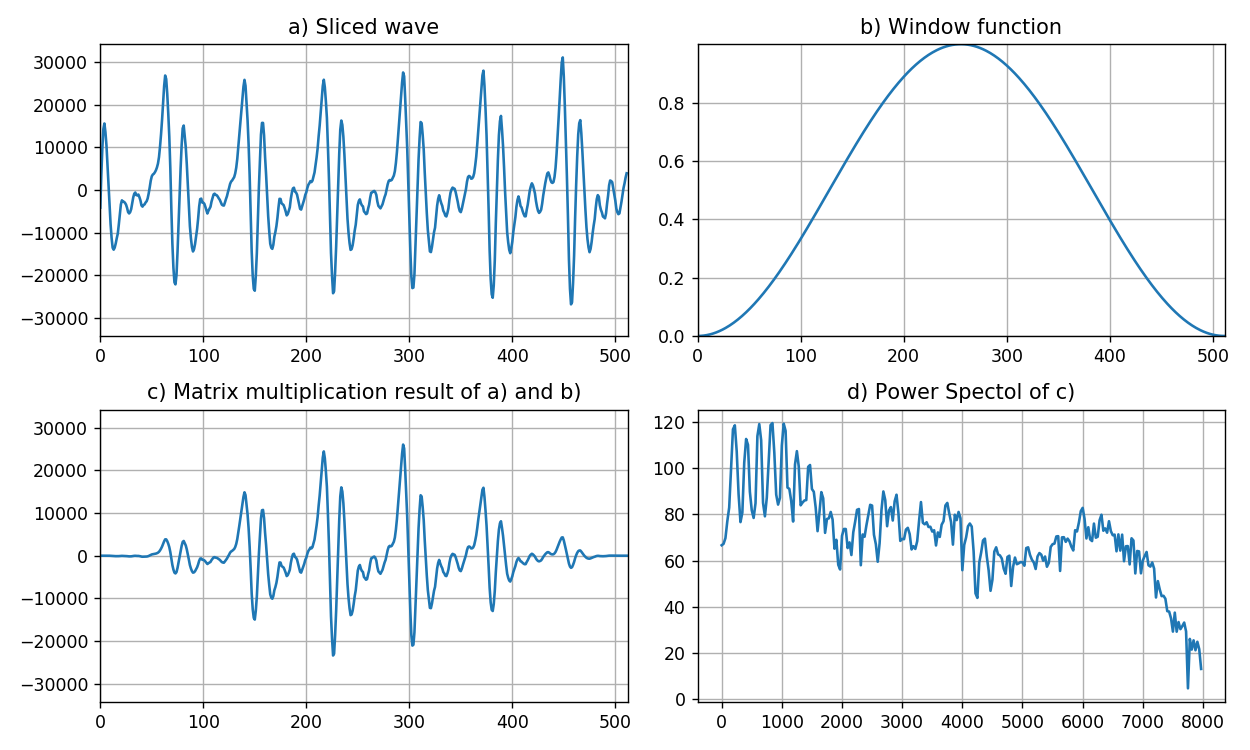

In [3]:
# 1.0秒後=16000フレーム目のSTFTを計算しよう
# 窓幅Nで波形を切り出す
ShortWav = x[16000:16000+N]

# 中心の値を大きく、中心から離れるほど値を小さくとるための窓関数
# ここではハミング窓という窓関数を使っているが、窓関数には他にもハニング窓などいろいろある
# Wikipedia: 窓関数を参照
#Window = np.hamming(N) # 中心から最も離れたところも0にならない
Window = np.hanning(N) # 中心から最も離れたところは0になる

# 切り出した波形と窓関数を要素ごとにかけ合わせる
WeightedShortWav = ShortWav * Window
PowerSpectol = 20*log10(np.abs(np.fft.fft(WeightedShortWav))) # パワースペクトルを計算
x_axis = np.fft.fftfreq(N, d=1.0/sampling_rate) # x軸の値を計算

fig = plt.figure(figsize=(10, 6)) # figure(図を配置する画面)のサイズを指定

ax0 = plt.subplot(2,2,1) 
ax0.plot(ShortWav)
ax0.set_title('a) Sliced wave')
ax0.set_xlim(0, N)
ax0.set_ylim(-1.1*max(abs(ShortWav)), 1.1*max(abs(ShortWav)))
ax0.grid()

ax1 = plt.subplot(2,2,2) 
ax1.plot(Window)
ax1.set_title('b) Window function')
ax1.set_xlim(0, N)
ax1.set_ylim(0, max(Window))
ax1.grid()

ax2 = plt.subplot(2,2,3) 
ax2.plot(WeightedShortWav)
ax2.set_title('c) Matrix multiplication result of a) and b)')
ax2.set_xlim(0, N)
ax2.set_ylim(-1.1*max(abs(ShortWav)), 1.1*max(abs(ShortWav)))
ax2.grid()

ax3 = plt.subplot(2,2,4) 
ax3.plot(x_axis[0:int(N/2)], PowerSpectol[0:int(N/2)])
ax3.set_title('d) Power Spectol of c)')
ax3.grid()

fig.tight_layout() # 図がはみ出さないようにレイアウト
plt.savefig('fig/SoundProcessing4-2.png') # 図を画像として保存'''

スペクトログラムで0から1kHz付近までの縞模様に相当する山5個が、上のd)のグラフで確認できたでしょうか？  
d)がスペクトログラムにおけるy軸方向の一つのバンドになります。  
今は1.0秒目のバンドでしたが、これが0.0秒目から最後まで並んでいると考えてください。